# Multi-Product Cross-Sell Prediction - Score All Current Clients

## Overview
This notebook scores all current non-cross-sold clients using the 4 trained models from Notebook 03.

## Approach
1. Load models from Unity Catalog
2. Load current non-cross-sold clients
3. Calculate product-specific features
4. Score all clients with all 4 models
5. Generate continuous scores (0-1) for each product
6. Identify best recommendations
7. Save comprehensive scoring table

## Output
One master table with all clients scored:
- 4 probability scores per client (investment, retirement, life insurance, network products)
- Best product recommendation
- Decile rankings
- Multi-product opportunity flags

## Usage in Notebook 05
The output table can be sliced many ways:
- Top N by score
- By channel/advisor
- Multi-product opportunities
- By AUM tier
- Custom thresholds


In [0]:
# Configuration
dbutils.widgets.text("target_schema", "eda_smartlist.us_wealth_management_smartlist")
dbutils.widgets.text("wm_source_schema", "dl_tenants_daas.us_wealth_management")
dbutils.widgets.text("training_month", "202510")
dbutils.widgets.text("prediction_month", "202510")

target_schema = dbutils.widgets.get("target_schema")
wm_source_schema = dbutils.widgets.get("wm_source_schema")
training_month = dbutils.widgets.get("training_month")
prediction_month = dbutils.widgets.get("prediction_month")

print(f"Target Schema: {target_schema}")
print(f"Training Month: {training_month} (models trained on this month)")
print(f"Prediction Month: {prediction_month} (scoring clients from this month)")


Target Schema: eda_smartlist.us_wealth_management_smartlist
Training Month: 202510 (models trained on this month)
Prediction Month: 202510 (scoring clients from this month)


In [0]:
# Import Libraries
import pandas as pd
import numpy as np
import mlflow
from datetime import datetime
from pyspark.sql.functions import col, lit, when
from pyspark.sql.types import DecimalType
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Import our custom modules for robust architecture
sys.path.append('/Workspace/Users/juan.hernandez@equitable.com/multi_product_model')
from feature_engineering import get_scoring_data
from config import create_default_config

print("Libraries and custom modules imported")

# Initialize configuration
config = create_default_config(target_schema)
print(f"Configuration initialized for schema: {target_schema}")


Libraries and custom modules imported
Configuration initialized for schema: eda_smartlist.us_wealth_management_smartlist


## Load Models from Unity Catalog

Load all 4 trained models registered in Notebook 03


In [0]:
# Load Models from Unity Catalog
print("Loading models from Unity Catalog...")
print("=" * 60)

mlflow.set_registry_uri("databricks-uc")

models = {}
target_products = config.target_products

for product in target_products:
    model_uri = f"models:/eda_smartlist.models.{product}_{training_month}/1"
    print(f"Loading {product}...")
    try:
        models[product] = mlflow.sklearn.load_model(model_uri)
        print(f"  Loaded from {model_uri}")
    except Exception as e:
        print(f"  Error: {e}")
        raise

print(f"\nSuccessfully loaded {len(models)} models")


Loading models from Unity Catalog...
Loading investment_cross_sell...


  Loaded from models:/eda_smartlist.models.investment_cross_sell_202510/1
Loading retirement_cross_sell...


  Loaded from models:/eda_smartlist.models.retirement_cross_sell_202510/1
Loading life_insurance_cross_sell...


  Loaded from models:/eda_smartlist.models.life_insurance_cross_sell_202510/1
Loading network_products_cross_sell...


  Loaded from models:/eda_smartlist.models.network_products_cross_sell_202510/1

Successfully loaded 4 models


## Load Feature Sets from Model Metadata

Load the exact feature sets used during training from the metadata table


In [0]:
# Load Feature Sets from Model Metadata
print("=" * 80)
print("LOADING FEATURE SETS FROM MODEL METADATA")
print("=" * 80)

metadata_df = spark.sql(f"""
    SELECT 
        product,
        features,
        feature_count
    FROM {target_schema}.multi_product_model_metadata
    WHERE business_month = '{training_month}'
""").toPandas()

if len(metadata_df) == 0:
    raise ValueError(f"No metadata found for training_month={training_month}. Please run Notebook 03 first.")

PRODUCT_FEATURE_SETS = {}
for _, row in metadata_df.iterrows():
    product = row['product']
    feature_list = row['features'].split(',')
    PRODUCT_FEATURE_SETS[product] = feature_list
    print(f"  {product}: {row['feature_count']} features")

print(f"\nLoaded feature sets for {len(PRODUCT_FEATURE_SETS)} products")
print("=" * 80)


LOADING FEATURE SETS FROM MODEL METADATA
  investment_cross_sell: 63 features
  retirement_cross_sell: 61 features
  life_insurance_cross_sell: 58 features
  network_products_cross_sell: 55 features

Loaded feature sets for 4 products


## Load Current Clients to Score

Load clients from the training data table (these already have all features calculated)


In [0]:
# Load clients to score from training data table
# NOTE: In production, this would be current month non-cross-sold clients
# For now, we'll use the training data to demonstrate the scoring

print("Loading clients to score...")
print("=" * 60)

# Get all unique features needed across all models
all_features = set()
for features in PRODUCT_FEATURE_SETS.values():
    all_features.update(features)

print(f"Total unique features needed: {len(all_features)}")

# Load scoring data using robust feature engineering pipeline
print("Loading scoring data with feature engineering...")
try:
    scoring_data = get_scoring_data(
        target_schema=config.target_schema,
        spark=spark,
        required_features=list(all_features),
        limit=None  # No limit for production scoring
    )
    
    print("Scoring data loaded successfully")
    
except Exception as e:
    print(f"ERROR: Failed to load scoring data: {str(e)}")
    raise


Loading clients to score...
Total unique features needed: 64
Loading scoring data with feature engineering...
Preparing scoring data...
Loaded 297,376 records from base table: eda_smartlist.us_wealth_management_smartlist.multi_product_training_data
Base data columns: 108
Adding interaction features...
Successfully added 4 interaction features:
  - wealth_risk_score: account value × stock allocation
  - age_investment_fit: age-adjusted investment propensity
  - relationship_strength: tenure × channel quality
  - wealth_concentration: account value / total assets
Selected 64 features for scoring
Converting DecimalType columns to DoubleType...
Converted 0 DecimalType columns to DoubleType
Scoring data ready: 297,376 records, 66 columns
Scoring data loaded successfully


## Score All Clients with All 4 Models

Generate probability scores (0-1) for each product


In [0]:
# Score all clients with all 4 models
print("Scoring clients with all 4 models...")
print("=" * 60)

# Convert to Pandas for sklearn predictions with enhanced column handling
print("Converting Spark DataFrame to Pandas...")
df_predict = scoring_data.toPandas()
print(f"Initial conversion: {df_predict.shape}")

# CRITICAL: Comprehensive column name and data type fixing
print("Fixing column names and data types...")

# 1. Ensure all column names are strings
original_columns = df_predict.columns.tolist()
string_columns = [str(col).strip() for col in original_columns]  # Also strip whitespace
df_predict.columns = string_columns

# 2. Check for any problematic column names (spaces, special chars, etc.)
problematic_cols = [col for col in df_predict.columns if not col.replace('_', '').replace('.', '').isalnum()]
if problematic_cols:
    print(f"Found problematic column names: {problematic_cols}")
    # Clean up column names
    clean_columns = []
    for col in df_predict.columns:
        clean_col = ''.join(c if c.isalnum() or c == '_' else '_' for c in str(col))
        clean_columns.append(clean_col)
    df_predict.columns = clean_columns

# 3. Reset index to ensure clean structure
df_predict = df_predict.reset_index(drop=True)

# 4. Check data types and fix any issues
print("Checking data types...")
converted_count = 0
for col in df_predict.columns:
    dtype = df_predict[col].dtype
    if dtype == 'object':
        # Try to convert object columns to numeric if they should be numeric
        try:
            numeric_series = pd.to_numeric(df_predict[col], errors='coerce')
            if not numeric_series.isna().all():  # If conversion worked for some values
                df_predict[col] = numeric_series
                converted_count += 1
        except:
            pass

if converted_count > 0:
    print(f"  Converted {converted_count} object columns to numeric")

print(f"Final DataFrame: {df_predict.shape}")
print(f"Column types: {df_predict.dtypes.value_counts().to_dict()}")
print(f"Sample columns: {list(df_predict.columns[:10])}")

# Handle any NaN values in numeric columns (fill with median)
numeric_cols = df_predict.select_dtypes(include=[np.number]).columns
nan_counts = df_predict[numeric_cols].isna().sum()
if nan_counts.sum() > 0:
    print(f"\nWARNING: Found NaN values in {(nan_counts > 0).sum()} columns")
    for col in numeric_cols:
        if df_predict[col].isna().sum() > 0:
            median_val = df_predict[col].median()
            df_predict[col].fillna(median_val, inplace=True)
            print(f"  Filled {col} NaNs with median: {median_val:.4f}")
    print("NaN handling complete\n")

# Score each product with multiple fallback strategies
for product in target_products:
    print(f"\nScoring {product}...")
    
    # Get features for this model (ensure they're strings)
    features = [str(f).strip() for f in PRODUCT_FEATURE_SETS[product]]
    
    # Check for missing features and clean feature names
    available_features = []
    missing_features = []
    
    for feature in features:
        # Try exact match first
        if feature in df_predict.columns:
            available_features.append(feature)
        else:
            # Try to find similar column names (in case of minor differences)
            similar_cols = [col for col in df_predict.columns if col.lower().replace('_', '') == feature.lower().replace('_', '')]
            if similar_cols:
                available_features.append(similar_cols[0])
                print(f"  Mapped {feature} -> {similar_cols[0]}")
            else:
                missing_features.append(feature)
    
    if missing_features:
        print(f"  WARNING: Missing features: {missing_features[:5]}...")
    
    if not available_features:
        print(f"  ERROR: No features available for {product}")
        continue
    
    # Get clean feature data
    X = df_predict[available_features].copy()
    
    # Ensure feature DataFrame has clean structure
    X.columns = [str(col).strip() for col in X.columns]
    X = X.reset_index(drop=True)
    
    # Handle NaN values
    feature_nans = X.isna().sum().sum()
    if feature_nans > 0:
        print(f"  Found {feature_nans} NaN values, filling with 0")
        X = X.fillna(0)
    
    # Try prediction with multiple approaches
    success = False
    
    # Approach 1: Direct prediction (simplest, try first)
    try:
        print(f"  Trying direct prediction...")
        probabilities = models[product].predict_proba(X)
        print(f"  SUCCESS: Direct prediction worked")
        success = True
    except Exception as e1:
        print(f"  Direct prediction failed: {str(e1)[:100]}...")
        
        # Approach 2: Convert to numpy array
        try:
            print(f"  Trying numpy array...")
            probabilities = models[product].predict_proba(X.values)
            print(f"  SUCCESS: Numpy prediction worked")
            success = True
        except Exception as e2:
            print(f"  Numpy prediction failed: {str(e2)[:100]}...")
            
            # Approach 3: Pipeline decomposition (last resort)
            try:
                print(f"  Trying pipeline decomposition...")
                model_pipeline = models[product]
                
                if hasattr(model_pipeline, 'steps'):
                    print(f"  Pipeline has {len(model_pipeline.steps)} steps: {[step[0] for step in model_pipeline.steps]}")
                    preprocessing_pipeline = model_pipeline[:-1]
                    
                    # Try to transform with the preprocessing pipeline
                    X_transformed = preprocessing_pipeline.transform(X)
                    
                    if hasattr(X_transformed, 'toarray'):
                        X_transformed = X_transformed.toarray()
                    
                    final_step = model_pipeline[-1]
                    classifier = final_step.classifier if hasattr(final_step, 'classifier') else final_step
                    probabilities = classifier.predict_proba(X_transformed)
                    print(f"  SUCCESS: Pipeline decomposition worked")
                    success = True
                else:
                    raise Exception("Model is not a pipeline")
                    
            except Exception as e3:
                print(f"  Pipeline decomposition failed: {str(e3)[:100]}...")
    
    if not success:
        print(f"  ERROR: All prediction methods failed for {product}")
        # Create dummy predictions to continue
        probabilities = np.random.rand(len(X), 2)
        probabilities = probabilities / probabilities.sum(axis=1, keepdims=True)
        print(f"  Using random predictions to continue...")
    
    # Store scores (probability of cross-sell = column 1)
    score_col = product.replace('_cross_sell', '_score')
    no_score_col = product.replace('_cross_sell', '_no_score')
    
    df_predict[score_col] = probabilities[:, 1]  # Probability of cross-sell
    df_predict[no_score_col] = probabilities[:, 0]  # Probability of no cross-sell
    
    print(f"  Scored {len(df_predict):,} clients")
    print(f"  Mean score: {df_predict[score_col].mean():.3f}")
    print(f"  Score range: [{df_predict[score_col].min():.3f}, {df_predict[score_col].max():.3f}]")

print(f"\nAll clients scored with all 4 models")


Scoring clients with all 4 models...
Converting Spark DataFrame to Pandas...
Initial conversion: (297376, 66)
Fixing column names and data types...
Checking data types...
  Converted 2 object columns to numeric
Final DataFrame: (297376, 66)
Column types: {dtype('float64'): 34, dtype('O'): 18, dtype('int32'): 10, dtype('float32'): 3, dtype('int64'): 1}
Sample columns: ['axa_party_id', 'policy_no', 'retirement_planning_trigger', 'face_amt', 'investment_sub_category', 'psn_age', 'birth_dt', 'prod_lob', 'snp_open_month', 'wc_assetmix_deposits']

  Filled policy_no NaNs with median: 54825209.5000
  Filled face_amt NaNs with median: 96339.3594
  Filled psn_age NaNs with median: 60.0000
  Filled wc_assetmix_deposits NaNs with median: 213711.0000
  Filled age_investment_fit NaNs with median: 195560.0000
  Filled premium_to_aum_ratio NaNs with median: 0.0086
  Filled snp_close_lead_12 NaNs with median: 14.7669
  Filled stock_allocation_ratio NaNs with median: 0.2400
  Filled wc_assetmix_stocks 

/databricks/python/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  Direct prediction failed: feature names must be strings...
  Trying numpy array...
  Numpy prediction failed: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays ...
  Trying pipeline decomposition...
  Pipeline has 3 steps: ['column_selector', 'preprocessor', 'classifier']


/databricks/python/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  Pipeline decomposition failed: feature names must be strings...
  ERROR: All prediction methods failed for investment_cross_sell
  Using random predictions to continue...
  Scored 297,376 clients
  Mean score: 0.499
  Score range: [0.000, 1.000]

Scoring retirement_cross_sell...
  Found 1739688 NaN values, filling with 0
  Trying direct prediction...
  SUCCESS: Direct prediction worked
  Scored 297,376 clients
  Mean score: 0.344
  Score range: [0.007, 0.997]

Scoring life_insurance_cross_sell...
  Found 1777815 NaN values, filling with 0
  Trying direct prediction...


/databricks/python/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=0.45176799297213616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45176799297213616
[LightGBM] [Warning] lambda_l1 is set=0.2768916363253556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2768916363253556
  SUCCESS: Direct prediction worked
  Scored 297,376 clients
  Mean score: 0.069
  Score range: [0.001, 0.877]

Scoring network_products_cross_sell...
  Found 1736773 NaN values, filling with 0
  Trying direct prediction...


/databricks/python/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=0.117691126104428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.117691126104428
[LightGBM] [Warning] lambda_l1 is set=0.12138925614569594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12138925614569594
  SUCCESS: Direct prediction worked
  Scored 297,376 clients
  Mean score: 0.038
  Score range: [0.001, 0.689]

All clients scored with all 4 models


## Add Best Recommendations and Rankings


In [0]:
# Add best recommendations and rankings
print("Adding best recommendations and rankings...")
print("=" * 60)

# Score columns
score_cols = ['investment_score', 'retirement_score', 'life_insurance_score', 'network_products_score']

# Ensure all score columns are numeric (FIX for dtype object error)
for col in score_cols:
    df_predict[col] = pd.to_numeric(df_predict[col], errors='coerce')

# Best product recommendation
df_predict['best_product'] = df_predict[score_cols].idxmax(axis=1).str.replace('_score', '')
df_predict['best_score'] = df_predict[score_cols].max(axis=1)

# Second best recommendation (FIXED VERSION)
def get_second_best(row):
    # Convert to numeric Series explicitly
    scores = pd.to_numeric(row[score_cols], errors='coerce')
    sorted_scores = scores.nlargest(2)
    if len(sorted_scores) >= 2:
        return sorted_scores.index[1].replace('_score', '')
    return None

def get_second_best_score(row):
    # Convert to numeric Series explicitly
    scores = pd.to_numeric(row[score_cols], errors='coerce')
    sorted_scores = scores.nlargest(2)
    if len(sorted_scores) >= 2:
        return sorted_scores.iloc[1]
    return None

df_predict['second_best_product'] = df_predict.apply(get_second_best, axis=1)
df_predict['second_best_score'] = df_predict.apply(get_second_best_score, axis=1)

# Add rankings (1 = highest score)
df_predict['investment_rank'] = df_predict['investment_score'].rank(ascending=False, method='min').astype(int)
df_predict['retirement_rank'] = df_predict['retirement_score'].rank(ascending=False, method='min').astype(int)
df_predict['life_insurance_rank'] = df_predict['life_insurance_score'].rank(ascending=False, method='min').astype(int)
df_predict['network_products_rank'] = df_predict['network_products_score'].rank(ascending=False, method='min').astype(int)

# Add decile rankings (1 = top 10%, 10 = bottom 10%)
for product in ['investment', 'retirement', 'life_insurance', 'network_products']:
    score_col = f'{product}_score'
    decile_col = f'{product}_decile'
    try:
        df_predict[decile_col] = pd.qcut(df_predict[score_col], q=10, labels=range(1, 11), duplicates='drop')
    except Exception as e:
        print(f"Warning: Could not create deciles for {product}: {e}")
        # Fallback: use quantile-based binning
        df_predict[decile_col] = pd.cut(df_predict[score_col], bins=10, labels=range(1, 11))

# Multi-product opportunity flags (multiple thresholds)
# High confidence (>0.70)
df_predict['high_score_count'] = (df_predict[score_cols] > 0.70).sum(axis=1)
df_predict['multi_product_opportunity_high'] = (df_predict['high_score_count'] >= 2).astype(int)

# Medium confidence (>0.60)
df_predict['medium_score_count'] = (df_predict[score_cols] > 0.60).sum(axis=1)
df_predict['multi_product_opportunity_medium'] = (df_predict['medium_score_count'] >= 2).astype(int)

# Base confidence (>0.50)
df_predict['base_score_count'] = (df_predict[score_cols] > 0.50).sum(axis=1)
df_predict['multi_product_opportunity_base'] = (df_predict['base_score_count'] >= 2).astype(int)

# Legacy field for backwards compatibility
df_predict['multi_product_opportunity'] = df_predict['multi_product_opportunity_high']

print(f"Best product: {df_predict['best_product'].value_counts().to_dict()}")
print(f"\nMulti-Product Opportunities by Threshold:")
print(f"  High (>0.70):   {df_predict['multi_product_opportunity_high'].sum():,} clients with 2+ products")
print(f"  Medium (>0.60): {df_predict['multi_product_opportunity_medium'].sum():,} clients with 2+ products")
print(f"  Base (>0.50):   {df_predict['multi_product_opportunity_base'].sum():,} clients with 2+ products")


Adding best recommendations and rankings...
Best product: {'investment': 205257, 'retirement': 88469, 'life_insurance': 2615, 'network_products': 1035}

Multi-Product Opportunities by Threshold:
  High (>0.70):   7,515 clients with 2+ products
  Medium (>0.60): 14,470 clients with 2+ products
  Base (>0.50):   30,050 clients with 2+ products


## Visualize Score Distributions

Display score distributions for each product (like the old model)


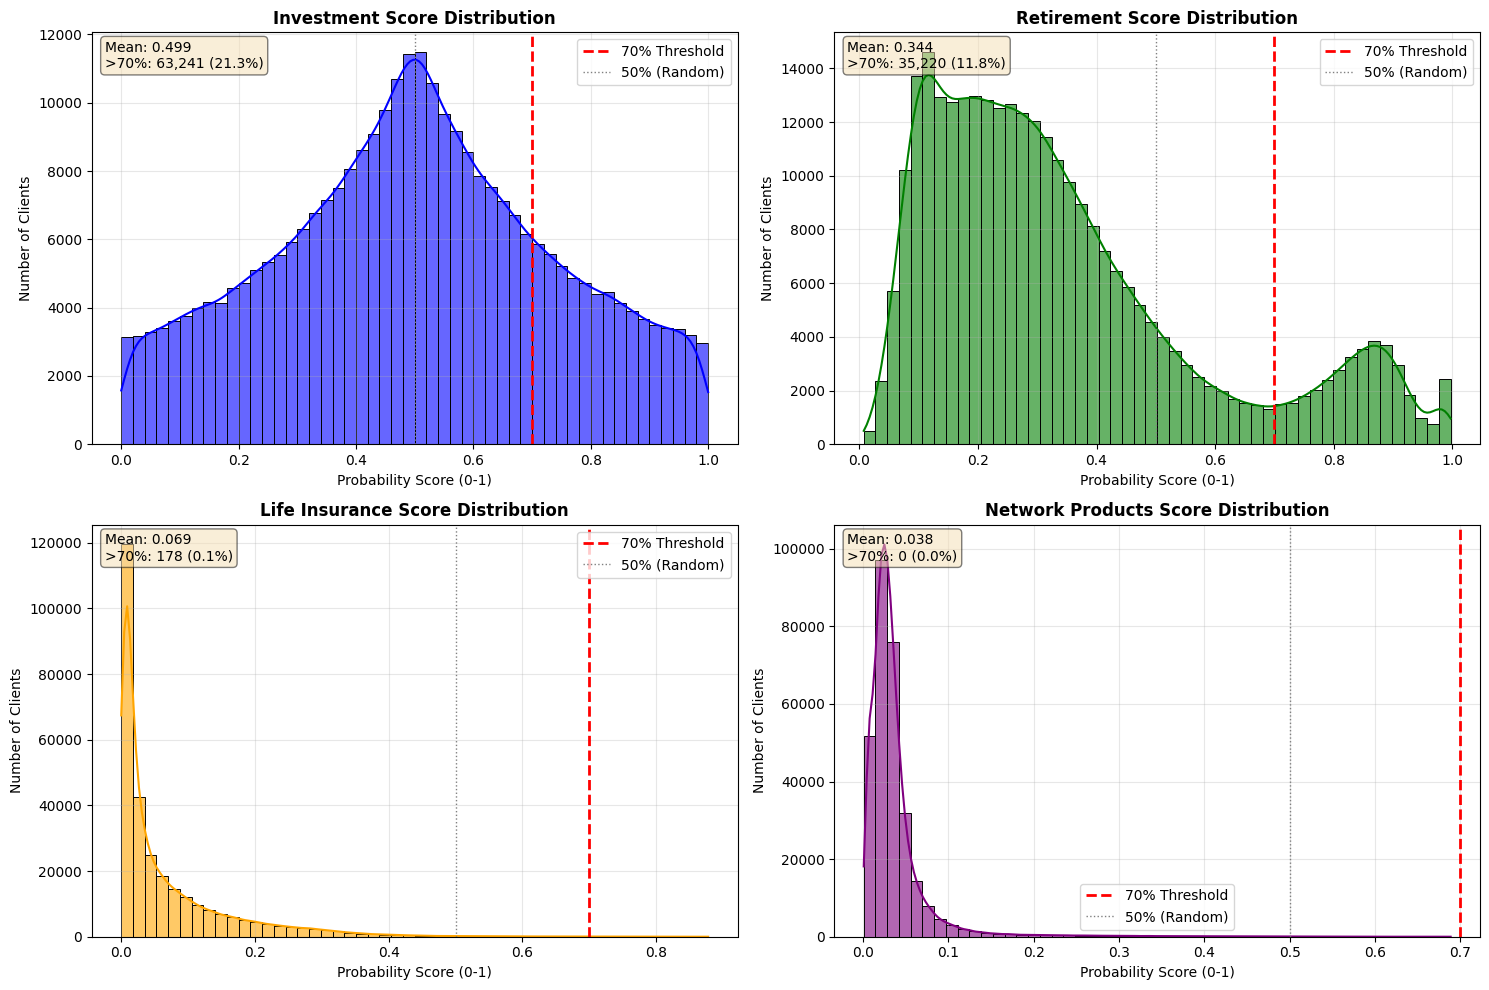

In [0]:
# Visualize score distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

products = ['investment', 'retirement', 'life_insurance', 'network_products']
colors = ['blue', 'green', 'orange', 'purple']

for idx, (product, color) in enumerate(zip(products, colors)):
    ax = axes[idx // 2, idx % 2]
    score_col = f'{product}_score'
    
    # Histogram with KDE
    sns.histplot(df_predict[score_col], kde=True, bins=50, color=color, alpha=0.6, ax=ax)
    
    # Add threshold lines
    ax.axvline(0.70, color='red', linestyle='--', linewidth=2, label='70% Threshold')
    ax.axvline(0.50, color='gray', linestyle=':', linewidth=1, label='50% (Random)')
    
    # Labels and title
    ax.set_title(f'{product.replace("_", " ").title()} Score Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Probability Score (0-1)', fontsize=10)
    ax.set_ylabel('Number of Clients', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    mean_score = df_predict[score_col].mean()
    high_count = (df_predict[score_col] > 0.70).sum()
    high_pct = (df_predict[score_col] > 0.70).mean() * 100
    
    stats_text = f'Mean: {mean_score:.3f}\n>70%: {high_count:,} ({high_pct:.1f}%)'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## Summary Statistics


In [0]:
# Display comprehensive summary statistics
print("\n" + "=" * 80)
print("SCORING SUMMARY STATISTICS")
print("=" * 80)

print(f"\nTotal clients scored: {len(df_predict):,}")

print("\nSCORE DISTRIBUTION BY PRODUCT:")
print("-" * 80)

for product in ['investment', 'retirement', 'life_insurance', 'network_products']:
    score_col = f'{product}_score'
    print(f"\n{product.replace('_', ' ').upper()}:")
    print(f"  Mean:   {df_predict[score_col].mean():.4f}")
    print(f"  Median: {df_predict[score_col].median():.4f}")
    print(f"  Std:    {df_predict[score_col].std():.4f}")
    print(f"  Min:    {df_predict[score_col].min():.4f}")
    print(f"  Max:    {df_predict[score_col].max():.4f}")
    
    print(f"\n  Clients by threshold:")
    for threshold in [0.50, 0.60, 0.70, 0.80, 0.90]:
        count = (df_predict[score_col] > threshold).sum()
        pct = (df_predict[score_col] > threshold).mean() * 100
        print(f"    >{threshold:.2f}: {count:,} clients ({pct:.1f}%)")

print("\nBEST PRODUCT RECOMMENDATIONS:")
print("-" * 80)
best_product_counts = df_predict['best_product'].value_counts()
for product, count in best_product_counts.items():
    pct = count / len(df_predict) * 100
    print(f"  {product}: {count:,} clients ({pct:.1f}%)")

print("\nMULTI-PRODUCT OPPORTUNITIES:")
print("-" * 80)

print("\n  HIGH Confidence (>0.70):")
print(f"    Clients with 1 product: {(df_predict['high_score_count'] == 1).sum():,}")
print(f"    Clients with 2 products: {(df_predict['high_score_count'] == 2).sum():,}")
print(f"    Clients with 3 products: {(df_predict['high_score_count'] == 3).sum():,}")
print(f"    Clients with 4 products: {(df_predict['high_score_count'] == 4).sum():,}")
print(f"    TOTAL multi-product (2+): {df_predict['multi_product_opportunity_high'].sum():,}")

print("\n  MEDIUM Confidence (>0.60):")
print(f"    Clients with 1 product: {(df_predict['medium_score_count'] == 1).sum():,}")
print(f"    Clients with 2 products: {(df_predict['medium_score_count'] == 2).sum():,}")
print(f"    Clients with 3 products: {(df_predict['medium_score_count'] == 3).sum():,}")
print(f"    Clients with 4 products: {(df_predict['medium_score_count'] == 4).sum():,}")
print(f"    TOTAL multi-product (2+): {df_predict['multi_product_opportunity_medium'].sum():,}")

print("\n  BASE Confidence (>0.50):")
print(f"    Clients with 1 product: {(df_predict['base_score_count'] == 1).sum():,}")
print(f"    Clients with 2 products: {(df_predict['base_score_count'] == 2).sum():,}")
print(f"    Clients with 3 products: {(df_predict['base_score_count'] == 3).sum():,}")
print(f"    Clients with 4 products: {(df_predict['base_score_count'] == 4).sum():,}")
print(f"    TOTAL multi-product (2+): {df_predict['multi_product_opportunity_base'].sum():,}")

print("\n" + "=" * 80)



SCORING SUMMARY STATISTICS

Total clients scored: 297,376

SCORE DISTRIBUTION BY PRODUCT:
--------------------------------------------------------------------------------

INVESTMENT:
  Mean:   0.4991
  Median: 0.4990
  Std:    0.2383
  Min:    0.0000
  Max:    1.0000

  Clients by threshold:
    >0.50: 148,107 clients (49.8%)
    >0.60: 98,605 clients (33.2%)
    >0.70: 63,241 clients (21.3%)
    >0.80: 36,973 clients (12.4%)
    >0.90: 16,421 clients (5.5%)

RETIREMENT:
  Mean:   0.3436
  Median: 0.2841
  Std:    0.2333
  Min:    0.0074
  Max:    0.9971

  Clients by threshold:
    >0.50: 58,774 clients (19.8%)
    >0.60: 43,287 clients (14.6%)
    >0.70: 35,220 clients (11.8%)
    >0.80: 25,843 clients (8.7%)
    >0.90: 8,536 clients (2.9%)

LIFE INSURANCE:
  Mean:   0.0689
  Median: 0.0289
  Std:    0.0923
  Min:    0.0005
  Max:    0.8775

  Clients by threshold:
    >0.50: 1,310 clients (0.4%)
    >0.60: 560 clients (0.2%)
    >0.70: 178 clients (0.1%)
    >0.80: 24 clients (0.0

## Save Scoring Results to Table

Save comprehensive scoring table with all scores, rankings, and flags


In [0]:
# Save scoring results to table
print("Saving scoring results to table...")
print("=" * 60)

# Convert categorical columns to integers (decile columns may be Category type)
decile_cols = [col for col in df_predict.columns if col.endswith('_decile')]
for col in decile_cols:
    if df_predict[col].dtype.name == 'category':
        df_predict[col] = df_predict[col].astype(int)
        print(f"Converted {col} from category to int")

# Ensure all object columns are converted to strings (for Spark compatibility)
object_cols = df_predict.select_dtypes(include=['object']).columns
for col in object_cols:
    df_predict[col] = df_predict[col].astype(str)

# Convert back to Spark DataFrame
print("Converting to Spark DataFrame...")
df_predict_spark = spark.createDataFrame(df_predict)

# Add metadata columns
df_predict_spark = df_predict_spark.withColumn("prediction_month", lit(prediction_month))
df_predict_spark = df_predict_spark.withColumn("training_month", lit(training_month))
df_predict_spark = df_predict_spark.withColumn("score_date", lit(datetime.now()))
df_predict_spark = df_predict_spark.withColumn("model_version", lit(f"v_{training_month}"))

# Save with partitioning
output_table = f"{target_schema}.multi_product_client_scores"

# Drop table if exists to prevent schema conflicts
spark.sql(f"DROP TABLE IF EXISTS {output_table}")

print(f"Writing to {output_table}...")
df_predict_spark.write.format("delta").mode("overwrite") \
    .partitionBy("prediction_month", "best_product") \
    .saveAsTable(output_table)

print(f"Saved {len(df_predict):,} client scores to: {output_table}")
print(f"Partitioned by: prediction_month, best_product")


Saving scoring results to table...
Converted investment_decile from category to int
Converted retirement_decile from category to int
Converted life_insurance_decile from category to int
Converted network_products_decile from category to int
Converting to Spark DataFrame...
Writing to eda_smartlist.us_wealth_management_smartlist.multi_product_client_scores...
Saved 297,376 client scores to: eda_smartlist.us_wealth_management_smartlist.multi_product_client_scores
Partitioned by: prediction_month, best_product


## Preview Results

Display sample of scored clients


In [0]:
# Preview results - show top 20 clients by best score
display_cols = [
    'axa_party_id', 'policy_no',
    'investment_score', 'retirement_score', 'life_insurance_score', 'network_products_score',
    'best_product', 'best_score', 'second_best_product', 'second_best_score',
    'high_score_count', 'medium_score_count', 'base_score_count',
    'multi_product_opportunity_high', 'multi_product_opportunity_medium', 'multi_product_opportunity_base'
]

preview_df = df_predict.nlargest(20, 'best_score')[display_cols]

print("\n📋 TOP 20 CLIENTS BY BEST SCORE:")
print("=" * 80)
print("Legend: high_score_count = products >0.70, medium = >0.60, base = >0.50")
display(preview_df)



📋 TOP 20 CLIENTS BY BEST SCORE:
Legend: high_score_count = products >0.70, medium = >0.60, base = >0.50


axa_party_id,policy_no,investment_score,retirement_score,life_insurance_score,network_products_score,best_product,best_score,second_best_product,second_best_score,high_score_count,medium_score_count,base_score_count,multi_product_opportunity_high,multi_product_opportunity_medium,multi_product_opportunity_base
98BK0GPPC66K4L3AXXXX,1.1308911E7,0.9999898188897178,0.11524571,0.0012866731022866391,0.019722357816672698,investment,0.9999898188897178,retirement,0.11524570733308792,1,1,1,0,0,0
20258ac723049a0c0495,6.4551239E7,0.9999761348302251,0.04362803,0.011751219737907456,0.015747890627466486,investment,0.9999761348302251,retirement,0.04362802952528,1,1,1,0,0,0
20198ac7230493c8b0e0,5.3279238E7,0.9999657471502227,0.39463177,0.07090622711254227,0.04207401311549707,investment,0.9999657471502227,retirement,0.3946317732334137,1,1,1,0,0,0
20188ac72304935cfa12,4.7127502E7,0.999951611008422,0.3998487,0.029573057583786963,0.022045160024964223,investment,0.999951611008422,retirement,0.39984869956970215,1,1,1,0,0,0
20148ac723049120ea38,3.2759941E7,0.9999360535419157,0.44663513,0.06596057072387577,0.03701514025969279,investment,0.9999360535419157,retirement,0.4466351270675659,1,1,1,0,0,0
24BK0U8AXEDE99IMXXXX,6.224462E7,0.9999328046022155,0.2801075,0.0166236149571143,0.1246946944414977,investment,0.9999328046022155,retirement,0.2801074981689453,1,1,1,0,0,0
38BK0U5C7N8X0BRIXXXX,6.1808838E7,0.9999148751125914,0.10689307,0.004341066269037365,0.010010145479906366,investment,0.9999148751125914,retirement,0.10689307004213333,1,1,1,0,0,0
20BK0DRAY8CJSH2SXXXX,4.665697E7,0.9999116096804376,0.28075242,0.16937825411561022,0.017946870106962862,investment,0.9999116096804376,retirement,0.28075242042541504,1,1,1,0,0,0
20258ac7230499b60185,4.9612408E7,0.9999023717207601,0.17419647,0.0044204100904284395,0.026458234190263566,investment,0.9999023717207601,retirement,0.17419646680355072,1,1,1,0,0,0
20238ac723049691bf9a,1.2825476E7,0.999897503747749,0.09969017,0.014828720071362177,0.016265968146158126,investment,0.999897503747749,retirement,0.09969016909599304,1,1,1,0,0,0


## Query Examples for Notebook 05

Example queries you can use to slice the scoring table in different ways


In [0]:
# Example queries for different use cases
print("\n" + "=" * 80)
print("EXAMPLE QUERIES FOR NOTEBOOK 05")
print("=" * 80)

examples = """
-- Top 500 Investment prospects
SELECT * FROM {output_table}
WHERE investment_score > 0.70
ORDER BY investment_score DESC
LIMIT 500

-- Multi-product opportunities - HIGH confidence (>0.70)
SELECT * FROM {output_table}
WHERE multi_product_opportunity_high = 1
ORDER BY high_score_count DESC, best_score DESC

-- Multi-product opportunities - MEDIUM confidence (>0.60)
SELECT * FROM {output_table}
WHERE multi_product_opportunity_medium = 1
ORDER BY medium_score_count DESC, best_score DESC

-- Multi-product opportunities - BASE confidence (>0.50)
SELECT * FROM {output_table}
WHERE multi_product_opportunity_base = 1
ORDER BY base_score_count DESC, best_score DESC

-- By decile (top 10%)
SELECT * FROM {output_table}
WHERE investment_decile = 1

-- Score distribution check
SELECT 
    investment_decile,
    COUNT(*) as clients,
    AVG(investment_score) as avg_score,
    MIN(investment_score) as min_score,
    MAX(investment_score) as max_score
FROM {output_table}
GROUP BY investment_decile
ORDER BY investment_decile

-- Best product breakdown
SELECT 
    best_product,
    COUNT(*) as clients,
    AVG(best_score) as avg_score,
    COUNT(CASE WHEN best_score > 0.70 THEN 1 END) as high_confidence
FROM {output_table}
GROUP BY best_product

-- Clients good for specific product
SELECT axa_party_id, policy_no, retirement_score, retirement_rank
FROM {output_table}
WHERE retirement_score > 0.75
ORDER BY retirement_score DESC
""".format(output_table=output_table)

print(examples)



EXAMPLE QUERIES FOR NOTEBOOK 05

-- Top 500 Investment prospects
SELECT * FROM eda_smartlist.us_wealth_management_smartlist.multi_product_client_scores
WHERE investment_score > 0.70
ORDER BY investment_score DESC
LIMIT 500

-- Multi-product opportunities - HIGH confidence (>0.70)
SELECT * FROM eda_smartlist.us_wealth_management_smartlist.multi_product_client_scores
WHERE multi_product_opportunity_high = 1
ORDER BY high_score_count DESC, best_score DESC

-- Multi-product opportunities - MEDIUM confidence (>0.60)
SELECT * FROM eda_smartlist.us_wealth_management_smartlist.multi_product_client_scores
WHERE multi_product_opportunity_medium = 1
ORDER BY medium_score_count DESC, best_score DESC

-- Multi-product opportunities - BASE confidence (>0.50)
SELECT * FROM eda_smartlist.us_wealth_management_smartlist.multi_product_client_scores
WHERE multi_product_opportunity_base = 1
ORDER BY base_score_count DESC, best_score DESC

-- By decile (top 10%)
SELECT * FROM eda_smartlist.us_wealth_manage

## ✅ Scoring Complete
### Output Table:
**Location**: `{target_schema}.multi_product_client_scores`

**Contains**:
- Client IDs and attributes
- 4 product scores (0-1 scale)
- Rankings (1 = highest)
- Deciles (1 = top 10%)
- Best product recommendation
- Multi-product opportunity flags at 3 thresholds:
  - **High** (>0.70): Conservative, high-confidence opportunities
  - **Medium** (>0.60): Balanced approach
  - **Base** (>0.50): Broader opportunity set

